# TUTORIAL 1: Adaptive Instance Normalization
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed Pytorch and Augmentare properly.

This tutorial uses the highly popular Adaptive Instance Normalization or **AdaIn** architecture. **Augmentare** provides a generalised implementation of **AdaIn**.

**Paper** - [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization by Xuan Huang & Serge Belongie.](https://arxiv.org/pdf/1703.06868.pdf)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from skimage import io, transform

# Pytorch and Torchvision Imports
from PIL import Image
import IPython.display as display
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Augmentare Imports
import augmentare
from augmentare.methods.style_transfer import *
from augmentare.plots.plot_losses import plot_losses

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING
This tutorial uses the [**Laparoscopic Image to Image Translation**](http://opencas.dkfz.de/image2image/) dataset for illustration purposes. We apply normalizations to the raw data set to speed up training with the mean and standard deviation being:

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

Here the content image is the simulated image and the style image is the real image that we want to aim for.

We then wrap the dataset in a **DataLoader**. Because in the following sections, said **DataLoader** is required to be passed as a parameter while training.

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

trans = transforms.Compose([transforms.RandomCrop(256),
                            transforms.ToTensor(),
                            normalize])

In [5]:
class PreprocessDataset(Dataset):
    def __init__(self, content_dir, style_dir, transforms=trans):
        content_dir_resized = content_dir + '_resized'
        style_dir_resized = style_dir + '_resized'
        if not (os.path.exists(content_dir_resized) and
                os.path.exists(style_dir_resized)):
            os.mkdir(content_dir_resized)
            os.mkdir(style_dir_resized)
            self._resize(content_dir, content_dir_resized)
            self._resize(style_dir, style_dir_resized)
        content_images = glob.glob((content_dir_resized + '/*'))
        np.random.shuffle(content_images)
        style_images = glob.glob(style_dir_resized + '/*')
        np.random.shuffle(style_images)
        self.images_pairs = list(zip(content_images, style_images))
        self.transforms = transforms

    @staticmethod
    def _resize(source_dir, target_dir):
        print(f'Start resizing {source_dir} ')

        #for i in tqdm(os.listdir(source_dir)):
        #    filename = os.path.basename(i)

        for i in range(500):
            filename = 'img{0:05}.png'.format(i)
    
            try:
                image = io.imread(os.path.join(source_dir, filename))
                if len(image.shape) == 3 and image.shape[-1] == 3:
                    H, W, _ = image.shape
                    if H < W:
                        ratio = W / H
                        H = 512
                        W = int(ratio * H)
                    else:
                        ratio = H / W
                        W = 512
                        H = int(ratio * W)
                    image = transform.resize(image, (H, W), mode='reflect', anti_aliasing=True)
                    io.imsave(os.path.join(target_dir, filename), image)
            except:
                continue

    def __len__(self):
        return len(self.images_pairs)

    def __getitem__(self, index):
        content_image, style_image = self.images_pairs[index]
        content_image = Image.open(content_image)
        style_image = Image.open(style_image)
        # content_image = io.imread(content_image, plugin='pil')
        # style_image = io.imread(style_image, plugin='pil')
        # Unfortunately,RandomCrop doesn't work with skimage.io
        if self.transforms:
            content_image = self.transforms(content_image)
            style_image = self.transforms(style_image)
        return content_image, style_image

In [6]:
con_path = "/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/sim"
sty_path = "/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/real"

In [ ]:
# Prepare dataset and dataLoader
train_dataset = PreprocessDataset(con_path, sty_path)
print(f'Length of train image pairs: {len(train_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

#### Show the content images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


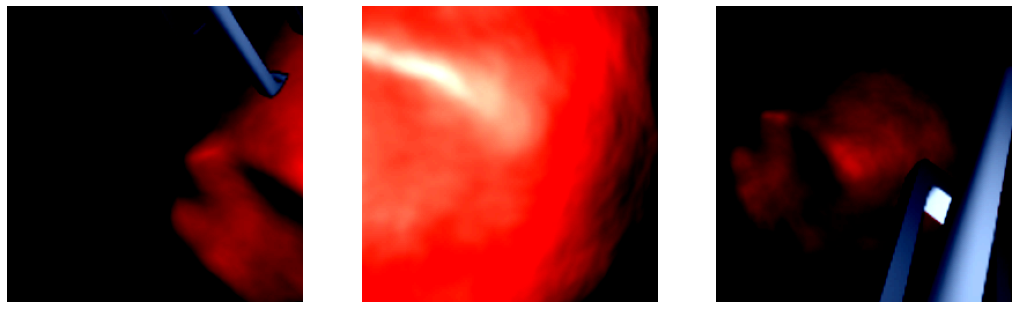

In [8]:
fig = plt.figure(figsize=(18,15))
n = len(train_dataset)
for i in range(3):
    fig.add_subplot(1, n, i + 1)
    plt.imshow(train_dataset[i][0].permute(1,2,0))
    plt.axis('off')
plt.show(block=True)

#### Show the style images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


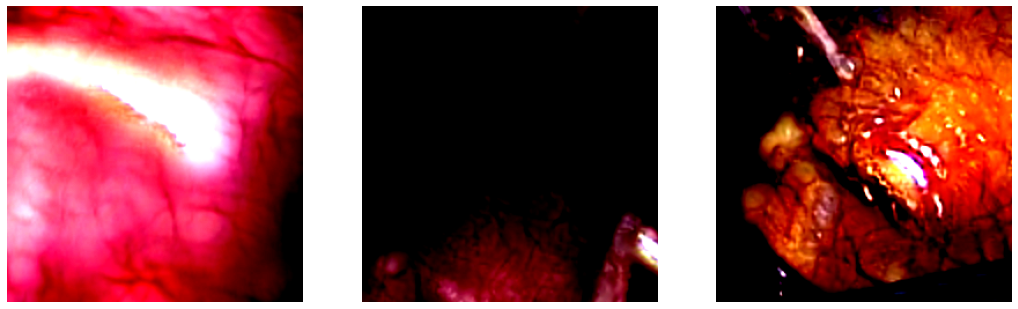

In [9]:
fig = plt.figure(figsize=(18,15))
n = len(train_dataset)
for i in range(3):
    fig.add_subplot(1, n, i + 1)
    plt.imshow(train_dataset[i][1].permute(1,2,0))
    plt.axis('off')
plt.show(block=True)

## NETWORK ARCHITECTURE : ADAIN

<span style="font-family:Roboto"> They use the first few layers of a fixed VGG-19 network to encode the content and style images. An AdaIN layer is used to perform style transfer in the feature space. A decoder is learned to invert the AdaIN output to the image spaces. They use the same VGG encoder to compute a content loss L<sub>c</sub> and a style loss L<sub>s</sub>. </span>

<img src="/home/vuong.nguyen/vuong/augmentare/tutorials/imgs/adain.png" alt="Picture" style="display: block; margin: 0 auto" />

In [17]:
model = ADAIN(device)

## OPTIMIZERS
This tutorial for the example about **AdaIN** optimized by the Adam optimizer.

**Adam** optimizer is often used to train neural networks, it usually avoids the need for hyperparameter search on parameters like learning rate, etc. **Adam** has hyperparameters that usually don't require much tuning:

-`Learning rate:` or step size. The weightes are updated (e.g. 0.001). A larger value (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values ​​(eg: 1.0e-5) slow down the learning right during training. Here we set $lr=1e-4$

In [18]:
optimizer = Adam(model.parameters(), lr=1e-4)

## TRAINING THE ADAIN NETWORK

Train AdaIN and return the losses.

Parameters:

`num_epochs:` The number of epochs you want to train your AdaIN

`train_loader:` The Dataloader for training (contains content and style images)

`optimizer:` The optimizer is used for training

Returns:

`loss_train:` The losses of AdaIN

In [ ]:
loss_train = model.train_network(
            num_epochs=49,
            train_loader= train_loader,
            optimizer= optimizer
        )

#### Plots the Losses

Plots losses for AdaIN on a common plot.

Parameters:

`losses:` A list of losses that you want to plot

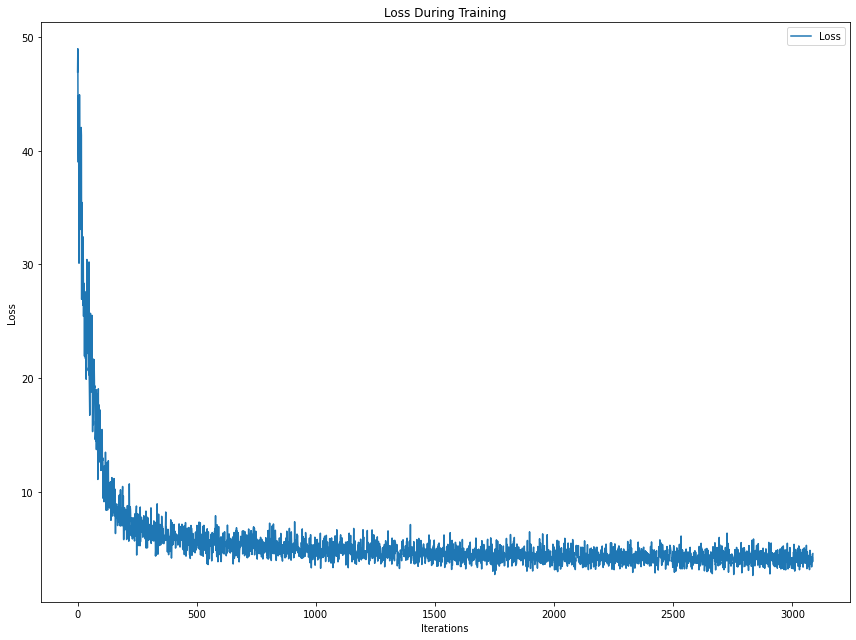

In [20]:
plot_losses(loss_train)

## VISUALIZE THE GENERATED DATA

In [21]:
def denorm(tensor, device):
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1).to(device)
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1).to(device)
    res = torch.clamp(tensor * std + mean, 0, 1)
    return res

In [22]:
content = Image.open('/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/sim/img00003.png')
style = Image.open('/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/real/img00003.png')

trans = transforms.Compose([transforms.ToTensor(),
                            normalize])

content_tensor = trans(content).unsqueeze(0).to(device)
style_tensor = trans(style).unsqueeze(0).to(device)

In [23]:
torch.cuda.empty_cache()

#### Styled images from the AdaIN.
A function that generates one image after training by AdaIn method.

Parameters:

`content_image:` Content image that we choose to stylizer

`style_image:` Style image that we choose for style transfer

`alpha:` Alpha control the fusion degree in AdaIn

Returns:

`gen_image:` Generated image

In [24]:
gen_image = model.adain_generate(content_tensor, style_tensor, alpha=1.0)
gen_image = denorm(gen_image, device)

In [25]:
new_im_out = np.clip(gen_image[0].permute(1, 2, 0).detach().cpu().numpy(), 0., 1.)
new_im_out = (new_im_out * 255).astype(np.uint8)

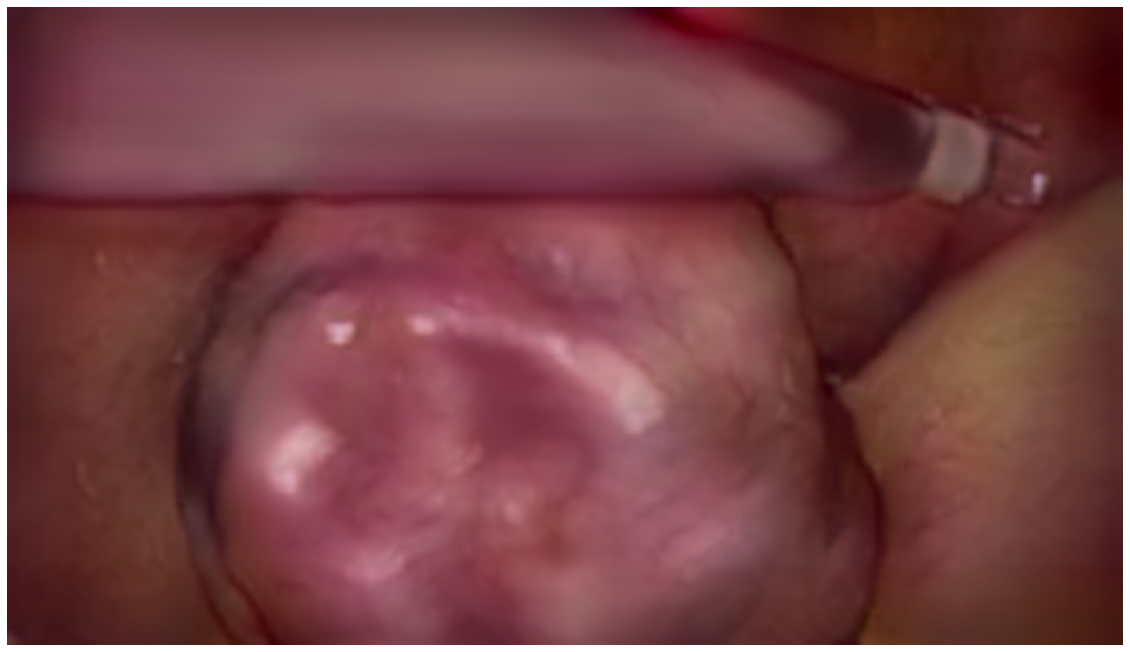

In [26]:
plt.figure(figsize=(20,25))
plt.imshow(new_im_out)
plt.axis('off')
plt.show()

In [27]:
vutils.save_image(gen_image, f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/adain/gen_image_adain_2.jpg', nrow=1)

#### Plot generated image

In [28]:
output = Image.open(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/adain/gen_image_adain_2.jpg')

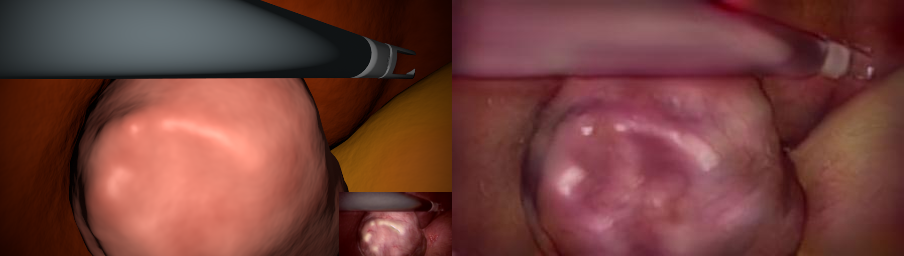

In [29]:
demo = Image.new('RGB', (content.width * 2, content.height))
output = output.resize(content.size)
style = style.resize((i // 4 for i in content.size))

demo.paste(content, (0, 0))
demo.paste(output, (content.width, 0))
demo.paste(style, (content.width-style.width, content.height - style.height))

display.display(demo)

In [30]:
demo.save(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/adain/output2.jpg')

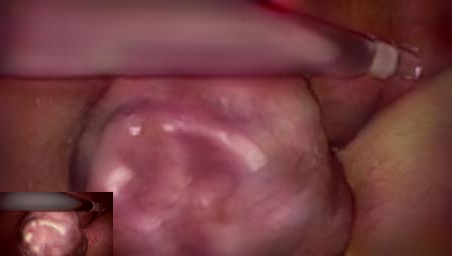

In [31]:
output.paste(style, (0, output.height - style.height))
display.display(output)